In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot
from importlib import reload

#-- show plots in notebook
%matplotlib inline

#-- Import analysis functions
import functions as func

#-- Read data into pandas from CSV
data = pd.read_csv(r'turnstile_weather_v2.csv')

# One other derived feature to explore (hour of day of week):
data['hour_day_week'] = data['day_week']*100 + data['hour']

In [ ]:
# Reload functions as func
reload(func)

# Analyzing the NYC Subway Dataset
## by Ian Edington

###Section 0. References
####References used for this project:
1. https://en.wikipedia.org/wiki/Mann–Whitney_U_test
2. https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php
3. http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
4. http://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html
5. http://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html
6. http://pandas.pydata.org/pandas-docs/stable/visualization.html#histograms
7. http://pandas.pydata.org/pandas-docs/stable/groupby.html
8. http://pypi.python.org/pypi/ggplot/
9. http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
10. http://stackoverflow.com/questions/12190874/pandas-sampling-a-dataframe
11. http://stackoverflow.com/questions/19711943/pandas-dataframe-to-dictionary-value
12. http://stackoverflow.com/questions/7001606/json-serialize-a-dictionary-with-tuples-as-key
13. http://statsmodels.sourceforge.net/0.5.0/generated/statsmodels.regression.linear_model.OLS.html
14. http://statsmodels.sourceforge.net/0.5.0/generated/statsmodels.regression.linear_model.OLS.fit.html
15. http://statsmodels.sourceforge.net/0.5.0/generated/statsmodels.regression.linear_model.RegressionResults.html
16. http://wiki.scipy.org/Cookbook/Matplotlib/BarCharts
17. http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm

###Section 1. Statistical Test
####1.1 Which statistical test did you use to analyze the NYC subway data?
The Mann-Whitney U test was used to determine if ridership on days where there was rainfall was significantly different than ridership on days where there was no rainfall. This same test was used to determine if ridership on days where there was fog was significantly different than ridership on days where there was no fog.
####Did you use a one-tail or a two-tail P value?
I used two-tailed P values in order to determine directionality.
####What is the null hypothesis?
The Mann-Whitney U test (also known as Wilcoxon rank-sum test)
is a non-parametric test that can be used to test, for two populations
with unknown distributions, if we draw randomly from each distribution,
whether one distribution is more likely to generate a higher value than
the other. Stated in mathematical terms, given random draws x from
population X and y from population Y, the standard two-tailed
hypotheses are as follows:

**H<sub>0</sub>: P(x > y) = 0.5<br/>
H<sub>1</sub>: P(x > y) ≠ 0.5**

####What is your p-critical value?
0.05

####1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

This test is applicable because the assumptions made by the Mann- Whitney U test are true about this data and because the question we were asking can be answered by this test.
Based on Wikipedia’s article these are the assumptions made by the
Mann-Whitney U test and evidence that this data set conforms to these assumptions.
1. All the observations from both groups are independent of each other:
We assume that the ridership of one hour is not based on the ridership of the previous hour or the previous day. This is a reasonable assumption since
2. The responses are at least ordinal: The dependent variable ENTRIESn_hourly is a continuous range of positive whole numbers.
3. The null hypothesis H0 is "The distributions of both populations are equal"
4. The alternative hypothesis H1 is "the probability of an observation from the population X exceeding an observation from the second population Y is different from the probability of an observation from Y exceeding an observation from X : P(X>Y)≠P(Y>X).”

From Laerd Statistics we have two additional assumptions:
5. You have one independent variable that consists of two categorical, independent groups:
This is true for both rain and fog variables: 1 and 0
6. You must determine whether the distribution of scores for both groups of your independent variable have the same shape or a different shape.

We can see based on the histograms for both rain and fog that the distributions have the same shape.

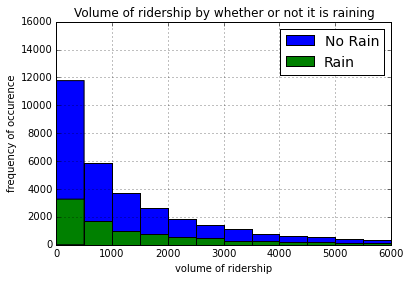

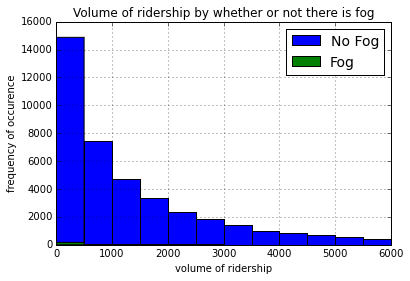

In [2]:
### Testing the hypothesis for Rain and Fog
#-- Select out the two sections for each one:
no_rain = data[data.rain == 0]['ENTRIESn_hourly']
rain = data[data.rain == 1]['ENTRIESn_hourly']
no_fog = data[data.fog == 0]['ENTRIESn_hourly']
fog = data[data.fog == 1]['ENTRIESn_hourly']

#-- Test selection: make a hist of the data
func.hist_MWW_suitability(no_rain, rain, rORf='rain').show()
func.hist_MWW_suitability(no_fog, fog, rORf='fog').show()

####1.3 What results did you get from this statistical test? P-values and the means for each of the two samples under test.

In [3]:
#-- compare Rain and Fog using Mann-Whitney statistic
MWU_rf = {'rain': list(func.mann_whitney_plus_means(no_rain, rain)),
        'fog': list(func.mann_whitney_plus_means(no_fog, fog))}

print(pd.DataFrame(MWU_rf, index= ['mean with ____',
                                   'mean without ____',
                                   'Mann-Whitney U-statistic',
                                   'Mann-Whitney p-value']))

                                     fog          rain
mean with ____               1889.116150  1.845539e+03
mean without ____            1631.980907  2.028196e+03
Mann-Whitney U-statistic  8167089.000000  1.536351e+08
Mann-Whitney p-value            0.006688  5.482139e-06


####1.4 What is the significance and interpretation of these results?
For the case of both Rain and Fog we reject the null hypothesis. This means that when it is raining the NYC subway is likely to have a hirer ridership than when it is not raining. Likewise for fog.

###Section 2. Linear Regression
####Feature Selection

#####All features

In [4]:
print(data.columns.tolist())

['UNIT', 'DATEn', 'TIMEn', 'ENTRIESn', 'EXITSn', 'ENTRIESn_hourly', 'EXITSn_hourly', 'datetime', 'hour', 'day_week', 'weekday', 'station', 'latitude', 'longitude', 'conds', 'fog', 'precipi', 'pressurei', 'rain', 'tempi', 'wspdi', 'meanprecipi', 'meanpressurei', 'meantempi', 'meanwspdi', 'weather_lat', 'weather_lon', 'hour_day_week']


#####Possible Colinearity
The variables related to Station might be colinear, ie. station, UNIT, latitude, longitude, weather_lat, weather_lon. If they are only one can be used in linear regression. This will test if they are perfectly colinear.

In [5]:
print(func.are_features_perfectly_colinearity(data, ['UNIT', 'station', 'latitude', 'longitude', 'weather_lat', 'weather_lon']))

perfectly colinear


#####Features that are acceptable for linear regression
UNIT, latitude, longitude, weather_lat, and weather_lon can be eliminated as features due to theis colinearity with station. ENTRIESn, EXITSn, EXITSn_hourly can be eliminated since they are derived from ENTRIESn_hourly. DATEn, TIMEn, and datetime were eliminated, however, hour, day_week, weekday, and hour_day_week (which were derived from datetime) will be included.

In [6]:
# split data into training data and testing data
tr_data, ts_data = func.split_tr_ts(data)

# initialize results dict
results = {}

# Features to use as dummy variables
dummy_vars = ['hour', 'day_week', 'weekday', 'hour_day_week', 'station', 'conds']

In [ ]:
# Feature to iterate over: Not used due to hour_day_week and hour day_week conflict
# features = ['hour', 'day_week', 'weekday', 'hour_day_week', 'station', 'conds', 'fog', 'precipi', 'pressurei', 'rain', 'tempi', 'wspdi', 'meanprecipi', 'meanpressurei', 'meantempi', 'meanwspdi']
# func.feature_testing(tr_data, ts_data, features, dummy_vars)

#####Another Colinearity problem
It was found that when hour, day_week, and hour_day_week were all in the same feature set, the model wouldn't converge meaning it was colinear. In order to test them both without eachother two feature testing runs were completed one with all the features except hour and day_week the other with all the features except hour_day_week. The results were put into the same results dictionary to compare more easily.

#####Test features to see which ones are the best by choosing 1 & 2 parameters to measure

In [7]:
#-- Results for feature without hour, day_week:
features = ['hour_day_week', 'weekday', 'station', 'conds', 'fog', 'precipi', 'pressurei', 'rain', 'tempi', 'wspdi', 'meanprecipi', 'meanpressurei', 'meantempi', 'meanwspdi']
func.feature_testing(tr_data, ts_data, features, dummy_vars, frange=(1,2), results=results)

#-- Results for feature without hour_day_week:
features = ['hour', 'day_week', 'weekday', 'station', 'conds', 'fog', 'precipi', 'pressurei', 'rain', 'tempi', 'wspdi', 'meanprecipi', 'meanpressurei', 'meantempi', 'meanwspdi']
func.feature_testing(tr_data, ts_data, features, dummy_vars, frange=(1,2), results=results)

In [8]:
results_df = pd.DataFrame(results, index=['rsquared', 'features', 'int_params', 'params_names', 'time in sec'])
results_df = results_df.transpose().sort(columns='rsquared', axis=0, ascending=False)
print(results_df[['rsquared']].head(5))

                        rsquared
hour_day_week station   0.504046
hour          station  0.4541068
day_week      station  0.3388125
weekday       station  0.3368753
station       wspdi    0.3309052


#####Create 

#####Testing top 10 features chosing 7 or 8 parameters

In [9]:
fixed_feat = ['hour_day_week', 'station']
features = ['tempi', 'meantempi', 'conds', 'pressurei', 'meanpressurei', 'rain', 'precipi', 'meanwspdi', 'weekday', 'wspdi', 'fog', 'meanprecipi']
func.feature_testing(tr_data, ts_data, features, dummy_vars, frange=(5,6), results=results, fixed_feat=fixed_feat)

#####Display top five results

In [10]:
results_df = pd.DataFrame(results, index=['rsquared', 'features', 'int_params', 'params_names', 'time in sec'])
results_df = results_df.transpose().sort(columns='rsquared', axis=0, ascending=False)
print(results_df[['rsquared']].head(5))

                                                                              rsquared
hour_day_week station meantempi conds pressurei meanpressurei meanwspdi fog  0.5136048
                                                meanwspdi     fog       NaN  0.5135418
                                                              weekday   fog  0.5135418
                                                              wspdi     fog  0.5135346
                                                meanpressurei wspdi     fog  0.5135237


#####Calculate all vaules for chosen features using all the data

In [11]:
features = ['hour_day_week', 'station', 'meantempi', 'conds', 'pressurei', 'meanpressurei', 'meanwspdi', 'fog']

values_array = data['ENTRIESn_hourly'].values

feature_array, test_feature_array, params_names = func.make_feature_arrays(data, data, features, dummy_vars)

intercept, params = func.OLS_linear_regression(feature_array, values_array)
predictions = (feature_array*params).sum(axis=1) + intercept
r_squared = func.compute_r_squared(values_array, predictions)


####2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
OLS using Statsmodels

####2.2 What features (input variables) did you use in your model?
I used hour_day_week, station, meantempi, conds, pressurei, meanpressurei, meanwspdi, and fog as the input variables of my model.
####Did you use any dummy variables as part of your features?
I used dummy variables for hour_day_week, station, and conds.

####2.3 Why did you select these features in your model?
I used these features because they had the greatest +ve impact on the r squared value. To calculate the r squared value I used parameters generated by the OLS model to make predictions for a set of test data, then compared the predictions to the recorded data.

####2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

In [12]:
print(dict(zip(params_names[0:5],params[0:5])))

{'fog': -519.29047597694955, 'meanpressurei': 653.80235063382281, 'meanwspdi': -14.90500696717417, 'pressurei': -902.77514391856062, 'meantempi': -19.498462665229269}


####2.5 What is your model’s R2 (coefficients of determination) value?

In [13]:
print(r_squared)

0.516912027377


####2.6 What does this R2 value mean for the goodness of fit for your regression model?
R^2 on its own isn’t a good indicator of a models fit. More graphical methods need to be used to determine if it is a good fit or not. Specifically, looking at the residuals. However, the R^2 means that 51.69% of the variation in Entries Hourly can be explained by this model meaning that 48.31% is still unexplained.
####Do you think this linear model to predict ridership is appropriate for this dataset, given this R2 value?
R^2 does not tell us if we have the right model, only how much of the variation can be explained by our model. If a large portion of the data can’t be explained by a model the R^2 will always be low wether or not we have a good fit. However, based on large tails in the Q-Q plot a linear model is not adaquite for predicting ridership.

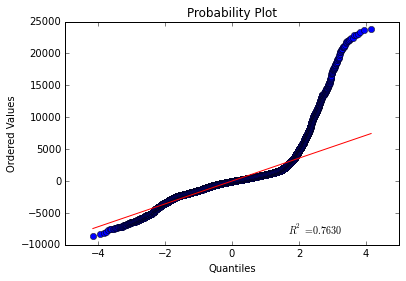

In [14]:
# figure of qqplot

residuals = values_array - predictions
probplot(residuals, plot=plt)
plt.show()

###Section 3. Visualization

####3.1 histogram of ridership for rainy/foggy days and non rainy/foggy days
In these histograms we can see that the data subset of Rain==0 (no rain) and Rain==1 (rain) have a similar distribution. This is important because one of the Mann-Whitney U-test assumptions is that the two sets it compares have similar distributions. This is also true for Fog.

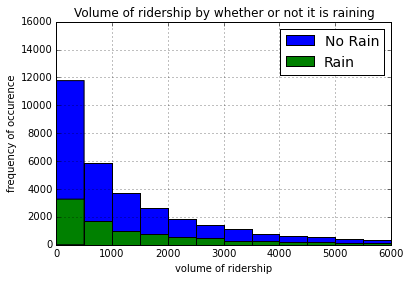

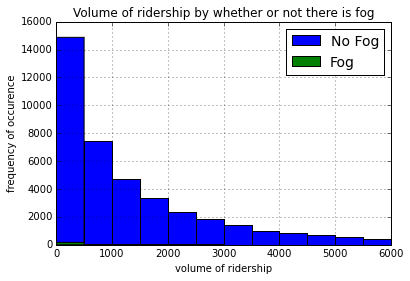

In [15]:
### Testing the hypothesis for Rain and Fog
#-- Select out the two sections for each one:
no_rain = data[data.rain == 0]['ENTRIESn_hourly']
rain = data[data.rain == 1]['ENTRIESn_hourly']
no_fog = data[data.fog == 0]['ENTRIESn_hourly']
fog = data[data.fog == 1]['ENTRIESn_hourly']

#-- Test selection: make a hist of the data
func.hist_MWW_suitability(no_rain, rain, rORf='rain').show()
func.hist_MWW_suitability(no_fog, fog, rORf='fog').show()

####3.2 Bar plot of Ridership by day-of-week and Ridership by hour of day
From these bar plots we can see that there are certain peak hours of the day and peak days the week. These large differences are why it was possible to more easily predict ridership based on day_week and hour. hour_day_week is an even better predictor however doesn't visualize well.

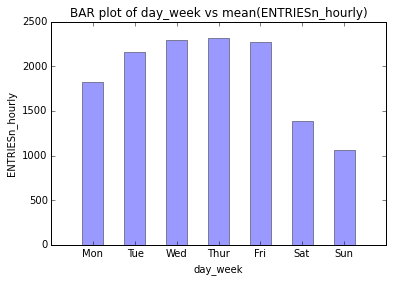

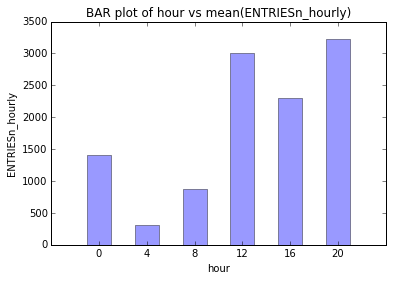

In [16]:
plt3_2_1 = func.barplot_day_week_vs_Entries(data)
plt3_2_2 = func.barplot_day_week_vs_Entries(data, feature = 'hour')

###Section 4. Conclusion

####4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?
We are 95% confident that more people ride the NYC subway when it is raining then when it is not raining. This is also true for when there is fog.

####4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.
From the Mann-Whitney U-test we know that more people ride the subway when it is raining. However, when we started the regression model rain fall was a very poor indicator of ridership. My understanding is that even though we are 95% confident that rain does have an effect on ridership the effect is so small that it isn’t useful for predicting ridership.

###Section 5. Reflection

####5.1 Please discuss potential shortcomings of the methods of your analysis, including: 1. Dataset, 2. Analysis, such as the linear regression model or statistical test.
Based on the Q-Q plot of the residuals a the current model is not a good fit. However, from what I understand this is the best we can do based on what we have learned so far.

The data is strongly skewed to the right. Meaning that the means of the data were not necessarily good indicators of what the data looked like. It is difficult for me to know exactly how this affected the analysis.

Another shortcoming due to analysis was feature selection. In the analysis I used the resulting R^2 values in order to select which features to use, however, this is not necessarily the best way to select features. For example one features may have a higher R^2 but we are not able to know them a head of time. Unfortunately I don’t know enough yet about feature selection to say if I did it well.

####5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?
Weather is a very poor indicator of ridership. People’s habits in terms of subway use seem to be more linked to their plans for the day than by if it will be raining. As much as rain affects their plans for the day it might affect ridership, however, whether or not it rains I still need to get to work :D